# Importing Libraries

In [1]:
import pandas as pd
from datetime import datetime,timedelta
from statsmodels.tsa.stattools import coint,adfuller
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np

# Selecting Instruments 

The instruments are stored in csv format in the data folder.

In [2]:
instruments = ["BILI","CRWD","DDOG","DKNG","DOCU","LVGO","ZM","ZS","MSFT","DELL",
               "ADBE","T","FB","STM","BABA","IAC","GOOG","AAPL","IBM","NVDA","INTC",
               "AMZN","WUBA"]

# Setting parameters 
The start and end dates are used to filter out data that we require. In this case we take almost a year or data!

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 365)


# Reads CSV files and wrangle the data

In [5]:
def get_close_data(instruments):
    price_data = pd.DataFrame()
    for instrument in instruments:
        instrument_price = pd.read_csv("data/"+instrument+", 1D.csv")
        instrument_price.set_index("time",inplace=True)
        price_data[instrument] = instrument_price["close"]
    return price_data
        
        
    

- It module below filter out data based on dates 
- It then drops columns out where there are null values 

In [6]:
def filter_data(instuments,start_date,end_date):
    start_timestamp = int(datetime.timestamp(start_date))
    end_timestamp = int(datetime.timestamp(end_date))
    price_data[(price_data.index > start_timestamp ) & (price_data.index < end_timestamp )]
    price_data.dropna(how = "any",axis =1, inplace=True)
    return price_data


# Conditions for pairs trading 
For pair trading we need to satisfy three conditions as follows :
- Cointegration 
- Correlation 
- Mean reversion

In [7]:
def check_cointegration(price_data,instruments):
    '''
    idx_i1 = index of instrument 1
    idx_i2 = index of instrument 2

    '''
    coint_pairs = list()
    for idx_i1 in range(len(instruments)-1):
        for idx_i2 in range(idx_i1 + 1,len(instruments)):
            close_1 = price_data[instruments[idx_i1]]
            close_2 = price_data[instruments[idx_i2]]
            t_stat, p_val, _ = coint(close_1,close_2)
            if p_val < 0.1:
                coint_pairs.append((instruments[idx_i1],instruments[idx_i2]))       
    return set(coint_pairs)
            
    

In [8]:
def check_correlation(price_data,instruments):
    '''
    idx_i1 = index of instrument 1
    idx_i2 = index of instrument 2

    '''
    corr_pairs = list()
    for idx_i1 in range(len(instruments)-1):
        for idx_i2 in range(idx_i1 + 1,len(instruments)):
            close_1 = price_data[instruments[idx_i1]]
            close_2 = price_data[instruments[idx_i2]]
            result = pearsonr(close_1,close_2)
            if result[0] > 0.8:
                corr_pairs.append((instruments[idx_i1],instruments[idx_i2]))       
    return set(corr_pairs)
            

In [9]:
def check_mean_reversion(price_data,instruments):
    '''
    idx_i1 = index of instrument 1
    idx_i2 = index of instrument 2

    '''
    rev_pairs = list()
    for idx_i1 in range(len(instruments)-1):
        for idx_i2 in range(idx_i1 + 1,len(instruments)):
            close_1 = price_data[instruments[idx_i1]]
            close_2 = price_data[instruments[idx_i2]]
            ratio = close_1 / close_2
            result = adfuller(ratio)
            if result[1] < 0.1:
                rev_pairs.append((instruments[idx_i1],instruments[idx_i2]))       
    return set(rev_pairs)
            

In [10]:
price_data = get_close_data(instruments)
price_data = filter_data(price_data,start_date,end_date)
instruments = list(price_data.columns)
coint_pairs = check_cointegration(price_data,instruments)
corr_pairs = check_correlation(price_data,instruments)
rev_pairs = check_mean_reversion(price_data,instruments)

In [11]:
common_pairs = coint_pairs.intersection(corr_pairs).intersection(rev_pairs)

In [12]:
common_pairs

{('BABA', 'INTC'), ('GOOG', 'INTC')}

# Choosing a pair

In [13]:
interested_stocks = ['GOOG', 'INTC']
ticker_1 =  interested_stocks[0]
ticker_2 =  interested_stocks[1]

data = price_data[interested_stocks]
stock_1 = price_data[ticker_1]
stock_2 = price_data[ticker_2]
spread_ratio = stock_1/stock_2

# Visualising Stock Prices 

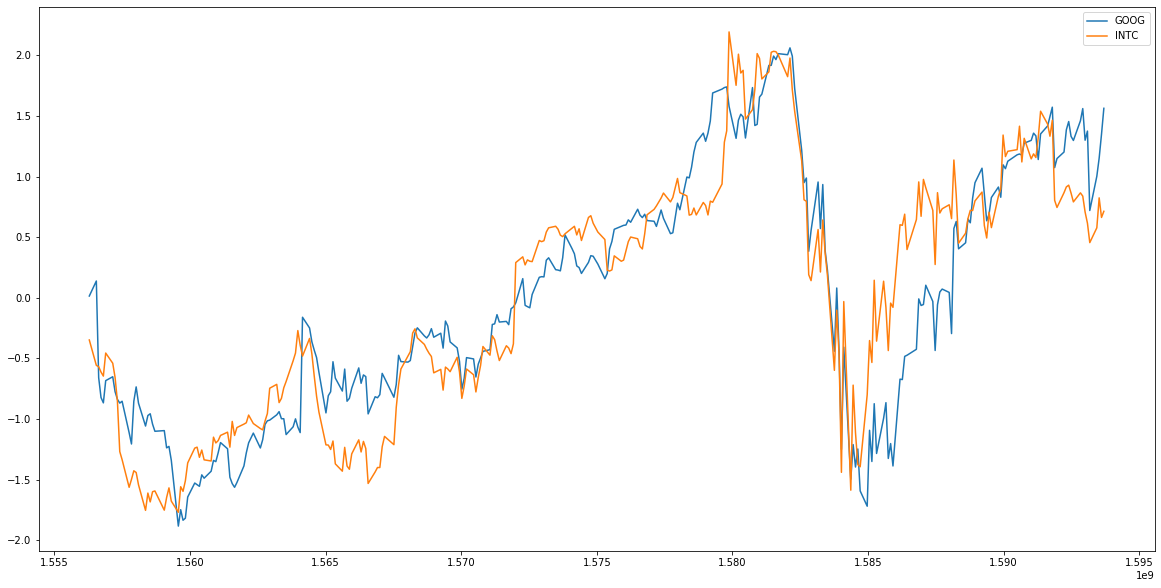

In [14]:
data_viz = data.copy()
data_viz[interested_stocks] = StandardScaler().fit_transform(data[interested_stocks])
plt.figure(figsize=(20,10))
for each in interested_stocks:
    plt.plot(data_viz[each],label='{}'.format(each))
plt.legend();

# Visualise Spread Ratio

In [15]:
def spread_ratio_plot(spread_ratio):
    spread_ratio.plot(label='Spread ratio of {} and {}'.format(ticker_1,ticker_2),figsize=(10,6), color='blue')
    plt.axhline(spread_ratio.mean(),c='r')
    plt.legend();
    


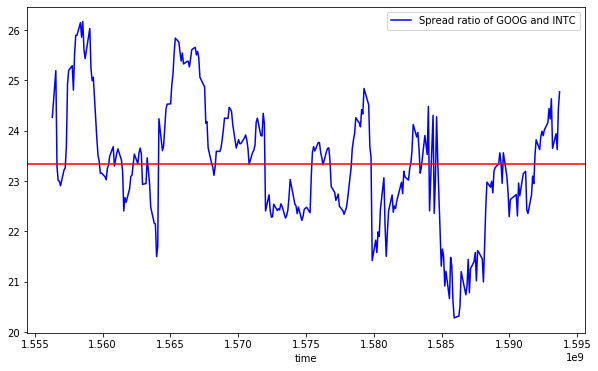

In [16]:
spread_ratio_plot(spread_ratio)

# Calculate Half life

In [17]:
def calc_half_time(spread_ratio):
    spread_lag = spread_ratio.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread_ratio - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    spread_lag2.rename(columns = {spread_lag2.keys()[0]:"const",spread_lag2.keys()[1]:"coeff"},inplace = True)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = round(-np.log(2) / res.params["coeff"],0)
    print("_________________________________________________________________________________________________")
    print("############                      Half-Life : "+str(halflife)+"                      ############")
    print("_________________________________________________________________________________________________")

    return halflife


In [18]:
window_size = int(calc_half_time(spread_ratio) * 2)


_________________________________________________________________________________________________
############                      Half-Life : 9.0                      ############
_________________________________________________________________________________________________


# Calculate the moving zscore

In [19]:
def calc_moving_zscore(spread_ratio,window_size):
    
    #1 day moving average of the price spread
    spreadratio_mavg_1 = spread_ratio.rolling(1).mean()

    # Moving average of the price spread
    spreadratio_mavg_TS = spread_ratio.rolling(window_size).mean()

    # Take a rolling standard deviation
    spreadratio_stdv_TS = spread_ratio.rolling(window_size).std()
    # Compute the z score for each day
    zscore_mvng_ratio = (spreadratio_mavg_1 - spreadratio_mavg_TS)/spreadratio_stdv_TS
        
    return zscore_mvng_ratio,spreadratio_mavg_1,spreadratio_mavg_TS



In [20]:
zscore_mvng_ratio,spreadratio_mavg_1,spreadratio_mavg_TS = calc_moving_zscore(spread_ratio,window_size)
    

In [21]:
def plot_moving_zscore(zscore_mvng_ratio,spreadratio_mavg_1,spreadratio_mavg_TS,window_size):
    plt.figure(figsize=(10,5))
    zscore_mvng_ratio.plot(label='Rolling '+str(window_size)+' period Z score for {} & {}'.format(ticker_1, ticker_2), color='blue')
    plt.title('Rolling '+str(window_size)+' period Z score for {} & {}'.format(ticker_1, ticker_2), color='red')
    plt.axhline(0, color='black')
    plt.axhline(2.0, color='red', linestyle='--')
    plt.axhline(3.0, color='green', linestyle='-')
    plt.axhline(-3.0, color='green', linestyle='-')
    plt.axhline(-2.0, color='red',linestyle='--')
    plt.legend(['Rolling '+str(window_size)+' period Z score for {} & {}'.format(ticker_1, ticker_2), 'Mean', '+-2.0 Sd', '+-3.0 Sd'])
    
    plt.figure(figsize=(10,5))
    plt.plot(spreadratio_mavg_1.index, spreadratio_mavg_1.values)
    plt.plot(spreadratio_mavg_TS.index, spreadratio_mavg_TS.values)
    plt.legend(['1 period MA Ratio', '{} periods MA Ratio'.format(window_size)])
    plt.title('MOVING AVERAGE COMPARISON', color='red')

    plt.ylabel('Moving Average Ratio of '+ str(window_size))


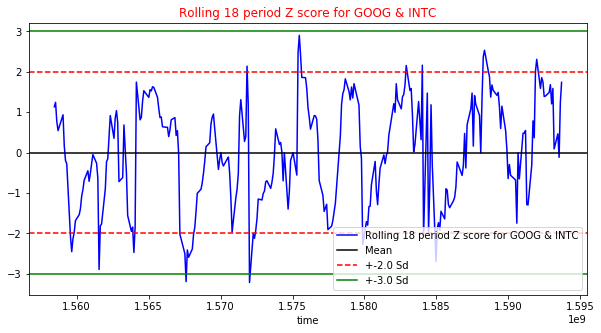

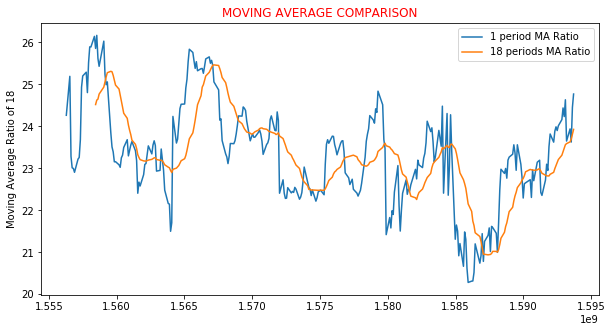

In [22]:
plot_moving_zscore(zscore_mvng_ratio,spreadratio_mavg_1,spreadratio_mavg_TS,window_size)


# Check for normality 

In [23]:
def plot_qq_plots(spread_ratio,zscore_mvng_ratio,window_size):
    qqplot(spread_ratio, line='s', label = "QQ plot of the rolling "+str(window_size)+" period Spread Ratio")
    plt.legend()
    qqplot(zscore_mvng_ratio, line='s', label = "QQ plot of the rolling "+str(window_size)+" period Z score")
    plt.legend();


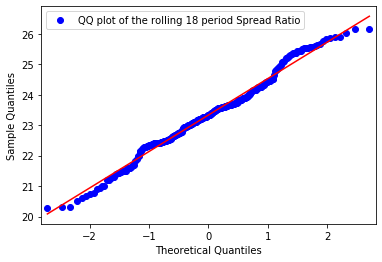

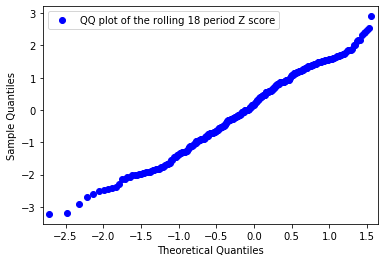

In [24]:
plot_qq_plots(spread_ratio,zscore_mvng_ratio,window_size)



# Plotting Signals

In [25]:
# Plot the ratios and buy and sell signals from z score

def plot_ratio_buy_sell(train_ratio,zscore_mvng_ratio):
    plt.figure(figsize=(15,7))
    train_ratio.plot()
    buy = train_ratio.copy()
    sell = train_ratio.copy()
    buy[zscore_mvng_ratio>-2] = np.nan
    sell[zscore_mvng_ratio<2] = np.nan
    buy[zscore_mvng_ratio.isnull()] = np.nan
    sell[zscore_mvng_ratio.isnull()] = np.nan
    buy.plot(color='g', linestyle='None', marker='^')
    sell.plot(color='r', linestyle='None', marker='^')
    plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
    plt.show()
    return buy,sell




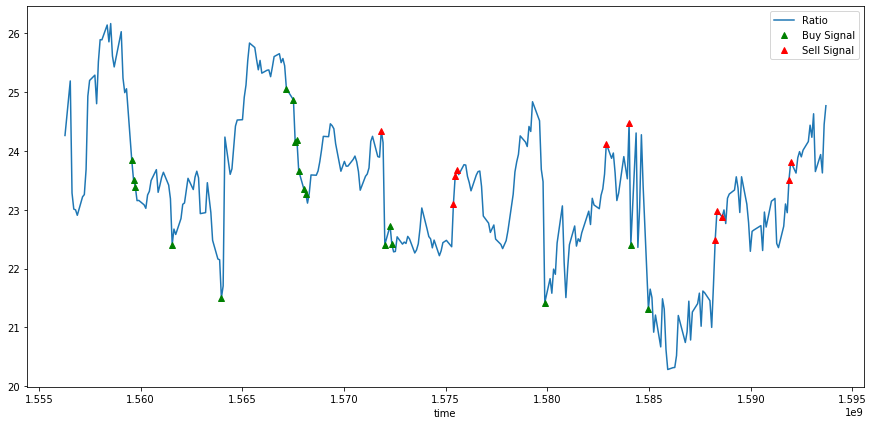

In [26]:
buy,sell = plot_ratio_buy_sell(spread_ratio,zscore_mvng_ratio)


In [27]:
def display_plot(ax_1_stock,ax_2_stock,ax_1_ticker,ax_2_ticker,sell_s1,sell_s2,buy_s1,buy_s2):
    axis_1_sell = sell_s1
    axis_2_sell = sell_s2
    axis_1_buy = buy_s1
    axis_2_buy = buy_s2

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('time')
    ax1.set_ylabel(ax_1_ticker+' Price', color="b")
    s1_plot = ax1.plot(ax_1_stock.index, ax_1_stock.values, color="b")
    sell_plot = ax1.plot(axis_1_sell,color='r', linestyle='None', marker='^')
    buy_plot = ax1.plot(axis_1_buy,color='g', linestyle='None', marker='^')
    ax1.tick_params(axis='y', labelcolor="b")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(ax_2_ticker +' Price', color="c")  # we already handled the x-label with ax1
    s2_plot = ax2.plot(ax_2_stock.index, ax_2_stock.values, color="c")
    ax2.tick_params(axis='y', labelcolor="c")
    sell_plot = ax2.plot(axis_2_sell,color='r', linestyle='None', marker='^')
    buy_plot = ax2.plot(axis_2_buy,color='g', linestyle='None', marker='^')


    plts = s1_plot+s2_plot+buy_plot+sell_plot
    labs = [ax_1_ticker,ax_2_ticker,"Buy Signal","Sell Signal"]
    ax1.legend(plts, labs)

    fig.set_size_inches([20,10])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


In [28]:
def calc_buy_sell_signal(buy,sell,train_S1,train_S2):
    buy_s1 = 0*train_S1.copy()
    buy_s1.loc[buy_s1 == 0] = np.nan
    sell_s1 = 0*train_S1.copy()
    sell_s1.loc[sell_s1 == 0] = np.nan

    buy_s2 = buy_s1.copy()
    sell_s2 = sell_s1.copy()



    # When buying the ratio, buy S1 and sell S2
    buy_s1[(buy[buy.notnull()] == True).index] = train_S1[(buy[buy.notnull()] == True).index]
    sell_s2[(buy[buy.notnull()] == True).index] = train_S2[(buy[buy.notnull()] == True).index]
    # When selling the ratio, sell S1 and buy S2 
    buy_s2[(sell[sell.notnull()] == True).index] = train_S2[(sell[sell.notnull()] == True).index]
    sell_s1[(sell[sell.notnull()] == True).index] = train_S1[(sell[sell.notnull()] == True).index]

    ax_1_stock = train_S1
    ax_2_stock = train_S2
    ax_1_ticker = ticker_1
    ax_2_ticker = ticker_2

    display_plot(ax_1_stock,ax_2_stock,ax_1_ticker,ax_2_ticker,sell_s1,sell_s2,buy_s1,buy_s2)


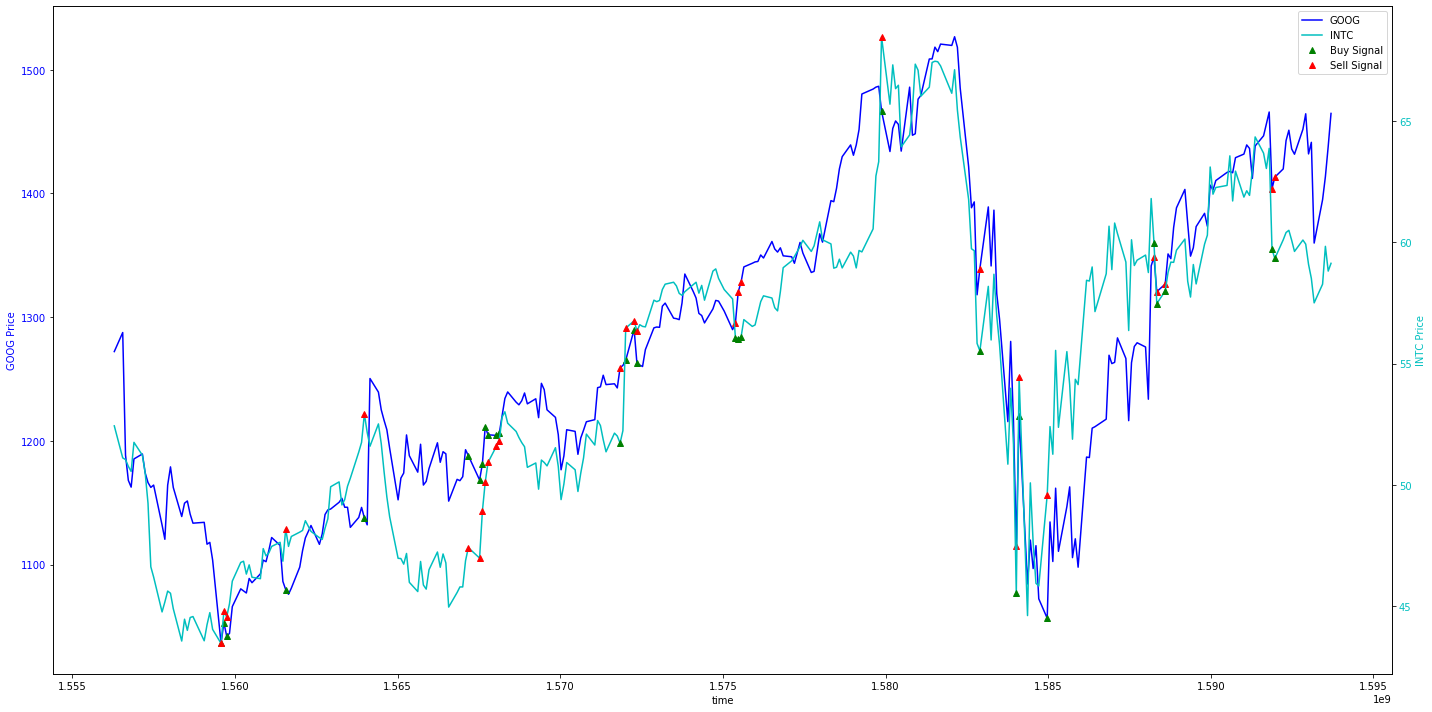

In [29]:
calc_buy_sell_signal(buy,sell,stock_1,stock_2)